# HDF5 Data Exploration

Explore the HDF5 file specified in `config.yaml`. 
Data is about energy consumption measurements from single-family homes (SFH), including:
- Heat pump data
- Household consumption data
- Buildings with and without PV systems

In [94]:
import pandas as pd
import numpy as np
import h5py
import yaml
import matplotlib.pyplot as plt
from pathlib import Path

# Set display options
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 200)

# Plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Configuration

In [95]:
# Load config from config.yaml
f_name:str = "config.yaml"
config_path = Path(__file__).parent / f_name if '__file__' in dir() else Path(f_name)
if not config_path.exists():
    config_path = Path(f'../preproc/{f_name}')

with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Get HDF5 file path
hdf5_path = config['input_file']
if not Path(hdf5_path).is_absolute():
    # Try relative to notebook location
    if not Path(hdf5_path).exists():
        hdf5_path = Path('..') / hdf5_path

print(f"HDF5 file path: {hdf5_path}")
print(f"File size: {Path(hdf5_path).stat().st_size / (1024**3):.2f} GB")

HDF5 file path: ../data/zenodo/2018_data_1min.hdf5
File size: 5.80 GB


## 2. Explore File Structure

In [96]:
def print_hdf5_structure(name, obj, indent=0):
    """Print HDF5 file structure recursively."""
    prefix = "  " * indent
    if isinstance(obj, h5py.Group):
        print(f"{prefix}[Group] {name}/")
    elif isinstance(obj, h5py.Dataset):
        print(f"{prefix}[Dataset] {name} - shape: {obj.shape}, dtype: {obj.dtype}")

max_subkeys: int = 7

# Open file and explore structure
with h5py.File(hdf5_path, 'r') as f:
    print("=" * 60)
    print("HDF5 FILE STRUCTURE")
    print("=" * 60)
    print(f"\nTop-level groups: {list(f.keys())}\n")
    
    for key in f.keys():
        print(f"\n--- {key} ---")
        if isinstance(f[key], h5py.Group):
            subkeys = list(f[key].keys())
            print(f"  Contains {len(subkeys)} items: {subkeys[:max_subkeys]}{'...' if len(subkeys) > max_subkeys else ''}")

HDF5 FILE STRUCTURE

Top-level groups: ['MISC', 'NO_PV', 'WITH_PV']


--- MISC ---
  Contains 2 items: ['ES1', 'PV1']

--- NO_PV ---
  Contains 34 items: ['SFH10', 'SFH11', 'SFH12', 'SFH14', 'SFH16', 'SFH17', 'SFH18']...

--- WITH_PV ---
  Contains 4 items: ['SFH13', 'SFH15', 'SFH26', 'SFH33']


In [97]:
# List all available keys using pandas HDFStore
store = pd.HDFStore(str(hdf5_path), 'r')
all_keys = store.keys()
print(f"Total number of datasets: {len(all_keys)}\n")

# Categorize keys
no_pv_keys = [k for k in all_keys if 'NO_PV' in k]
with_pv_keys = [k for k in all_keys if 'WITH_PV' in k]
misc_keys = [k for k in all_keys if 'MISC' in k]

print(f"NO_PV datasets: {len(no_pv_keys)}")
print(f"WITH_PV datasets: {len(with_pv_keys)}")
print(f"MISC datasets: {len(misc_keys)}")

store.close()

Total number of datasets: 80

NO_PV datasets: 68
WITH_PV datasets: 8
MISC datasets: 4


In [98]:
# Print all keys organized by category
print("\nAll available datasets:")
print("\n--- NO_PV ---")
for k in sorted(no_pv_keys):
    print(f"  {k}")

print("\n--- WITH_PV ---")
for k in sorted(with_pv_keys):
    print(f"  {k}")

print("\n--- MISC ---")
for k in sorted(misc_keys):
    print(f"  {k}")


All available datasets:

--- NO_PV ---
  /NO_PV/SFH10/HEATPUMP
  /NO_PV/SFH10/HOUSEHOLD
  /NO_PV/SFH11/HEATPUMP
  /NO_PV/SFH11/HOUSEHOLD
  /NO_PV/SFH12/HEATPUMP
  /NO_PV/SFH12/HOUSEHOLD
  /NO_PV/SFH14/HEATPUMP
  /NO_PV/SFH14/HOUSEHOLD
  /NO_PV/SFH16/HEATPUMP
  /NO_PV/SFH16/HOUSEHOLD
  /NO_PV/SFH17/HEATPUMP
  /NO_PV/SFH17/HOUSEHOLD
  /NO_PV/SFH18/HEATPUMP
  /NO_PV/SFH18/HOUSEHOLD
  /NO_PV/SFH19/HEATPUMP
  /NO_PV/SFH19/HOUSEHOLD
  /NO_PV/SFH20/HEATPUMP
  /NO_PV/SFH20/HOUSEHOLD
  /NO_PV/SFH21/HEATPUMP
  /NO_PV/SFH21/HOUSEHOLD
  /NO_PV/SFH22/HEATPUMP
  /NO_PV/SFH22/HOUSEHOLD
  /NO_PV/SFH23/HEATPUMP
  /NO_PV/SFH23/HOUSEHOLD
  /NO_PV/SFH24/HEATPUMP
  /NO_PV/SFH24/HOUSEHOLD
  /NO_PV/SFH25/HEATPUMP
  /NO_PV/SFH25/HOUSEHOLD
  /NO_PV/SFH27/HEATPUMP
  /NO_PV/SFH27/HOUSEHOLD
  /NO_PV/SFH28/HEATPUMP
  /NO_PV/SFH28/HOUSEHOLD
  /NO_PV/SFH29/HEATPUMP
  /NO_PV/SFH29/HOUSEHOLD
  /NO_PV/SFH3/HEATPUMP
  /NO_PV/SFH3/HOUSEHOLD
  /NO_PV/SFH30/HEATPUMP
  /NO_PV/SFH30/HOUSEHOLD
  /NO_PV/SFH31/HEATPUMP
  /NO_P

### Conclusion

For me rather the household energy need curves are interesting, I do not deal with transformers, inverters, or such households, where PV production is included into the household consumption (WITH_PV category is like this).

## 3. Load Sample Data into DataFrames

In [99]:
# Load a sample heat pump dataset
store = pd.HDFStore(str(hdf5_path), 'r')

# Pick one building to explore
sample_building = 'NO_PV/SFH10'
print(f"Loading data for building: {sample_building}\n")

# Load heat pump data
df_heatpump = store[f'/{sample_building}/HEATPUMP']
print(f"Heat pump data shape: {df_heatpump.shape}")
print(f"Heat pump columns: {list(df_heatpump.columns)}\n")

# Load household data
df_household = store[f'/{sample_building}/HOUSEHOLD']
print(f"Household data shape: {df_household.shape}")
print(f"Household columns: {list(df_household.columns)}")

store.close()

Loading data for building: NO_PV/SFH10

Heat pump data shape: (525600, 10)
Heat pump columns: ['S_TOT', 'PF_TOT', 'P_1', 'P_2', 'P_3', 'P_TOT', 'Q_1', 'Q_2', 'Q_3', 'Q_TOT']

Household data shape: (525600, 22)
Household columns: ['S_1', 'S_2', 'S_3', 'S_TOT', 'I_1', 'I_2', 'I_3', 'PF_1', 'PF_2', 'PF_3', 'PF_TOT', 'P_1', 'P_2', 'P_3', 'P_TOT', 'Q_1', 'Q_2', 'Q_3', 'Q_TOT', 'U_1', 'U_2', 'U_3']


In [100]:
# Convert index to datetime if needed
if not isinstance(df_heatpump.index, pd.DatetimeIndex):
    df_heatpump.index = pd.to_datetime(df_heatpump.index, unit='s')
if not isinstance(df_household.index, pd.DatetimeIndex):
    df_household.index = pd.to_datetime(df_household.index, unit='s')

## 2.1 Missing value analysis

In [101]:
# Check for missing values in heat pump data
print("Missing values in Heat Pump data:")
missing_hp = df_heatpump.isnull().sum()
missing_hp_pct = (df_heatpump.isnull().sum() / len(df_heatpump) * 100).round(2)
missing_summary_hp = pd.DataFrame({
    'Missing Count': missing_hp,
    'Missing %': missing_hp_pct
})
print(missing_summary_hp[missing_summary_hp['Missing Count'] > 0])

print(f"\nTotal rows with any missing: {df_heatpump.isnull().any(axis=1).sum()}")

Missing values in Heat Pump data:
        Missing Count  Missing %
S_TOT          180539      34.35
PF_TOT         180539      34.35
P_1            183453      34.90
P_2            183453      34.90
P_3            183453      34.90
P_TOT          180539      34.35
Q_1            183453      34.90
Q_2            183453      34.90
Q_3            183453      34.90
Q_TOT          180539      34.35

Total rows with any missing: 183453


In [102]:
# Check for missing values in household data
print("Missing values in Household data:")
missing_hh = df_household.isnull().sum()
missing_hh_pct = (df_household.isnull().sum() / len(df_household) * 100).round(2)
missing_summary_hh = pd.DataFrame({
    'Missing Count': missing_hh,
    'Missing %': missing_hh_pct
})
print(missing_summary_hh[missing_summary_hh['Missing Count'] > 0])

print(f"\nTotal rows with any missing: {df_household.isnull().any(axis=1).sum()}")

Missing values in Household data:
        Missing Count  Missing %
S_1            180539      34.35
S_2            180539      34.35
S_3            180539      34.35
S_TOT          180539      34.35
I_1            180539      34.35
I_2            180539      34.35
I_3            180539      34.35
PF_1           180539      34.35
PF_2           180539      34.35
PF_3           180539      34.35
PF_TOT         180539      34.35
P_1            180539      34.35
P_2            180539      34.35
P_3            180539      34.35
P_TOT          180539      34.35
Q_1            180539      34.35
Q_2            180539      34.35
Q_3            180539      34.35
Q_TOT          180539      34.35
U_1            180539      34.35
U_2            180539      34.35
U_3            180539      34.35

Total rows with any missing: 180539


In [103]:
print("Heat pump data preview:")
df_heatpump = df_heatpump.dropna()
df_heatpump.head(10)

Heat pump data preview:


,S_TOT,PF_TOT,P_1,P_2,P_3,P_TOT,Q_1,Q_2,Q_3,Q_TOT
2018-05-08 09:33:00,14.552516,0.184009,0.0,10.93,0.0,5.406492,0.0,24.07,0.0,11.906154
2018-05-08 09:34:00,14.552516,0.184009,0.0,10.93,0.0,5.406492,0.0,24.07,0.0,11.906154
2018-05-08 09:35:00,14.552516,0.184009,0.0,10.93,0.0,5.406492,0.0,24.07,0.0,11.906154
2018-05-08 09:36:00,14.552516,0.184009,0.0,10.93,0.0,5.406492,0.0,24.07,0.0,11.906154
2018-05-08 09:37:00,14.552516,0.184009,0.0,10.93,0.0,5.406492,0.0,24.07,0.0,11.906154
2018-05-08 09:38:00,14.552516,0.184009,0.0,10.93,0.0,5.406492,0.0,24.07,0.0,11.906154
2018-05-08 09:39:00,14.552516,0.184009,0.0,10.93,0.0,5.406492,0.0,24.07,0.0,11.906154
2018-05-08 09:40:00,14.552516,0.184009,0.0,10.93,0.0,5.406492,0.0,24.07,0.0,11.906154
2018-05-08 09:41:00,14.552516,0.184009,0.0,10.93,0.0,5.406492,0.0,24.07,0.0,11.906154
2018-05-08 09:42:00,14.552516,0.184009,0.0,10.93,0.0,5.406492,0.0,24.07,0.0,11.906154


In [104]:
print("Heat pump data types:")
df_heatpump.info()

Heat pump data types:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 342147 entries, 2018-05-08 09:33:00 to 2018-12-31 23:59:00
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   S_TOT   342147 non-null  float64
 1   PF_TOT  342147 non-null  float64
 2   P_1     342147 non-null  float64
 3   P_2     342147 non-null  float64
 4   P_3     342147 non-null  float64
 5   P_TOT   342147 non-null  float64
 6   Q_1     342147 non-null  float64
 7   Q_2     342147 non-null  float64
 8   Q_3     342147 non-null  float64
 9   Q_TOT   342147 non-null  float64
dtypes: float64(10)
memory usage: 28.7 MB


In [105]:
print("Household data preview:")
df_household = df_household.dropna()
df_household.head(10)

Household data preview:


,S_1,S_2,S_3,S_TOT,I_1,I_2,I_3,PF_1,PF_2,PF_3,PF_TOT,P_1,P_2,P_3,P_TOT,Q_1,Q_2,Q_3,Q_TOT,U_1,U_2,U_3
2018-05-06 08:59:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,226.5,0.0,0.0
2018-05-06 09:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,226.5,0.0,0.0
2018-05-06 09:01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,226.5,0.0,0.0
2018-05-06 09:02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,226.5,0.0,0.0
2018-05-06 09:03:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,226.5,0.0,0.0
2018-05-06 09:04:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,226.5,0.0,0.0
2018-05-06 09:05:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,226.5,0.0,0.0
2018-05-06 09:06:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,226.5,0.0,0.0
2018-05-06 09:07:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,226.5,0.0,0.0
2018-05-06 09:08:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,226.5,0.0,0.0


## 4. Basic Statistics

In [106]:
print("=" * 60)
print("HEAT PUMP STATISTICS")
print("=" * 60)
df_heatpump.describe()

HEAT PUMP STATISTICS


,S_TOT,PF_TOT,P_1,P_2,P_3,P_TOT,Q_1,Q_2,Q_3,Q_TOT
count,342147.000000,342147.000000,342147.000000,342147.000000,342147.000000,342147.000000,342147.000000,342147.000000,342147.000000,342147.000000
mean,760.317946,0.538677,224.137620,213.133724,184.936259,622.184640,89.861179,128.209076,85.132958,303.157162
std,2037.956255,0.219740,659.817144,641.569931,636.563917,1934.410081,226.617017,256.041781,215.143813,697.571552
min,8.395000,0.102833,-0.008333,0.865000,-0.328333,0.865000,-30.011666,-25.538333,-26.485000,-14.191666
25%,29.121667,0.357667,0.000000,10.531667,0.000000,10.526667,0.000000,23.851667,0.000000,23.873333
50%,30.710000,0.370667,0.000000,10.875000,0.000000,10.871667,0.000000,25.011667,0.000000,25.113333
75%,66.886665,0.789833,0.000000,52.721666,0.000000,53.085000,0.000000,37.813334,0.000000,38.021666
max,14069.128255,1.000000,4753.815104,4640.206624,4508.806641,13902.828451,796.983348,885.003337,704.481669,2335.981649


In [107]:
print("=" * 60)
print("HOUSEHOLD STATISTICS")
print("=" * 60)
df_household.describe()

HOUSEHOLD STATISTICS


,S_1,S_2,S_3,S_TOT,I_1,I_2,I_3,PF_1,PF_2,PF_3,PF_TOT,P_1,P_2,P_3,P_TOT,Q_1,Q_2,Q_3,Q_TOT,U_1,U_2,U_3
count,345061.000000,345061.000000,345061.000000,345061.000000,345061.000000,345061.000000,345061.000000,345061.000000,345061.000000,345061.000000,345061.000000,345061.000000,345061.000000,345061.000000,345061.000000,345061.000000,345061.000000,345061.000000,345061.000000,345061.000000,345061.000000,345061.000000
mean,229.646519,196.849724,292.448743,718.958303,0.996707,0.851294,1.269057,0.896985,0.734985,0.940013,0.949813,212.953023,150.509696,276.418765,639.871185,-6.303902,93.314803,35.861758,122.865189,230.687343,229.065831,228.463384
std,221.525935,155.375311,319.855807,455.265338,0.967629,0.674328,1.394344,0.105604,0.127912,0.097821,0.095812,222.105863,145.205638,304.360007,436.889615,60.762170,87.232087,105.152899,148.963560,1.642631,20.242989,20.214465
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-114.805000,-100.640001,-70.354998,-223.351664,222.533333,0.000000,0.000000
25%,159.241669,115.546668,142.869998,470.949997,0.688333,0.501667,0.620000,0.876833,0.683500,0.952667,0.937500,143.581665,92.225001,138.006666,410.420003,-63.448334,33.190000,-8.986667,33.221668,229.600004,230.066666,229.500003
50%,185.768333,165.668332,179.010000,592.951670,0.805000,0.716667,0.778333,0.916000,0.750167,0.964333,0.973833,170.169998,136.739999,169.823334,518.678335,-2.486667,91.845001,-3.873333,104.605000,230.716670,231.300001,230.633336
75%,225.800001,271.404999,335.148331,842.234996,0.980000,1.173333,1.451667,0.954000,0.818667,0.972000,0.993000,209.018333,189.396667,310.154999,756.463338,48.263334,164.150002,22.616667,194.573331,231.800001,232.449999,231.749997
max,4862.576660,3830.871663,5082.004964,7017.441569,21.245000,16.825000,22.253333,1.000000,1.000000,1.000000,1.000000,4834.590007,3823.238322,5012.645020,6988.006673,480.294998,412.386668,1486.716654,1684.323324,239.049998,239.516670,238.399996


In [108]:
# Data info
print("\n=== Heat Pump Data Info ===")
print(df_heatpump.info())

print("\n=== Household Data Info ===")
print(df_household.info())


=== Heat Pump Data Info ===
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 342147 entries, 2018-05-08 09:33:00 to 2018-12-31 23:59:00
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   S_TOT   342147 non-null  float64
 1   PF_TOT  342147 non-null  float64
 2   P_1     342147 non-null  float64
 3   P_2     342147 non-null  float64
 4   P_3     342147 non-null  float64
 5   P_TOT   342147 non-null  float64
 6   Q_1     342147 non-null  float64
 7   Q_2     342147 non-null  float64
 8   Q_3     342147 non-null  float64
 9   Q_TOT   342147 non-null  float64
dtypes: float64(10)
memory usage: 28.7 MB
None

=== Household Data Info ===
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 345061 entries, 2018-05-06 08:59:00 to 2018-12-31 23:59:00
Data columns (total 22 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   S_1     345061 non-null  float64
 1   S_2     345061 non-null  float

In [109]:
# Time range
print(f"\nTime range:")
print(f"  Start: {df_heatpump.index.min()}")
print(f"  End: {df_heatpump.index.max()}")
print(f"  Duration: {df_heatpump.index.max() - df_heatpump.index.min()}")
print(f"  Resolution: {(df_heatpump.index[1] - df_heatpump.index[0]).total_seconds():.0f} seconds")


Time range:
  Start: 2018-05-08 09:33:00
  End: 2018-12-31 23:59:00
  Duration: 237 days 14:26:00
  Resolution: 60 seconds


## 6. Time Series Visualization

In [110]:
# Select key columns for visualization
# Look for power-related columns
power_cols_hp = [c for c in df_heatpump.columns if 'P_' in c or 'P' == c or 'power' in c.lower()]
power_cols_hh = [c for c in df_household.columns if 'P_' in c or 'P' == c or 'power' in c.lower()]

print(f"Power columns in heat pump data: {power_cols_hp}")
print(f"Power columns in household data: {power_cols_hh}")

Power columns in heat pump data: ['P_1', 'P_2', 'P_3', 'P_TOT']
Power columns in household data: ['P_1', 'P_2', 'P_3', 'P_TOT']


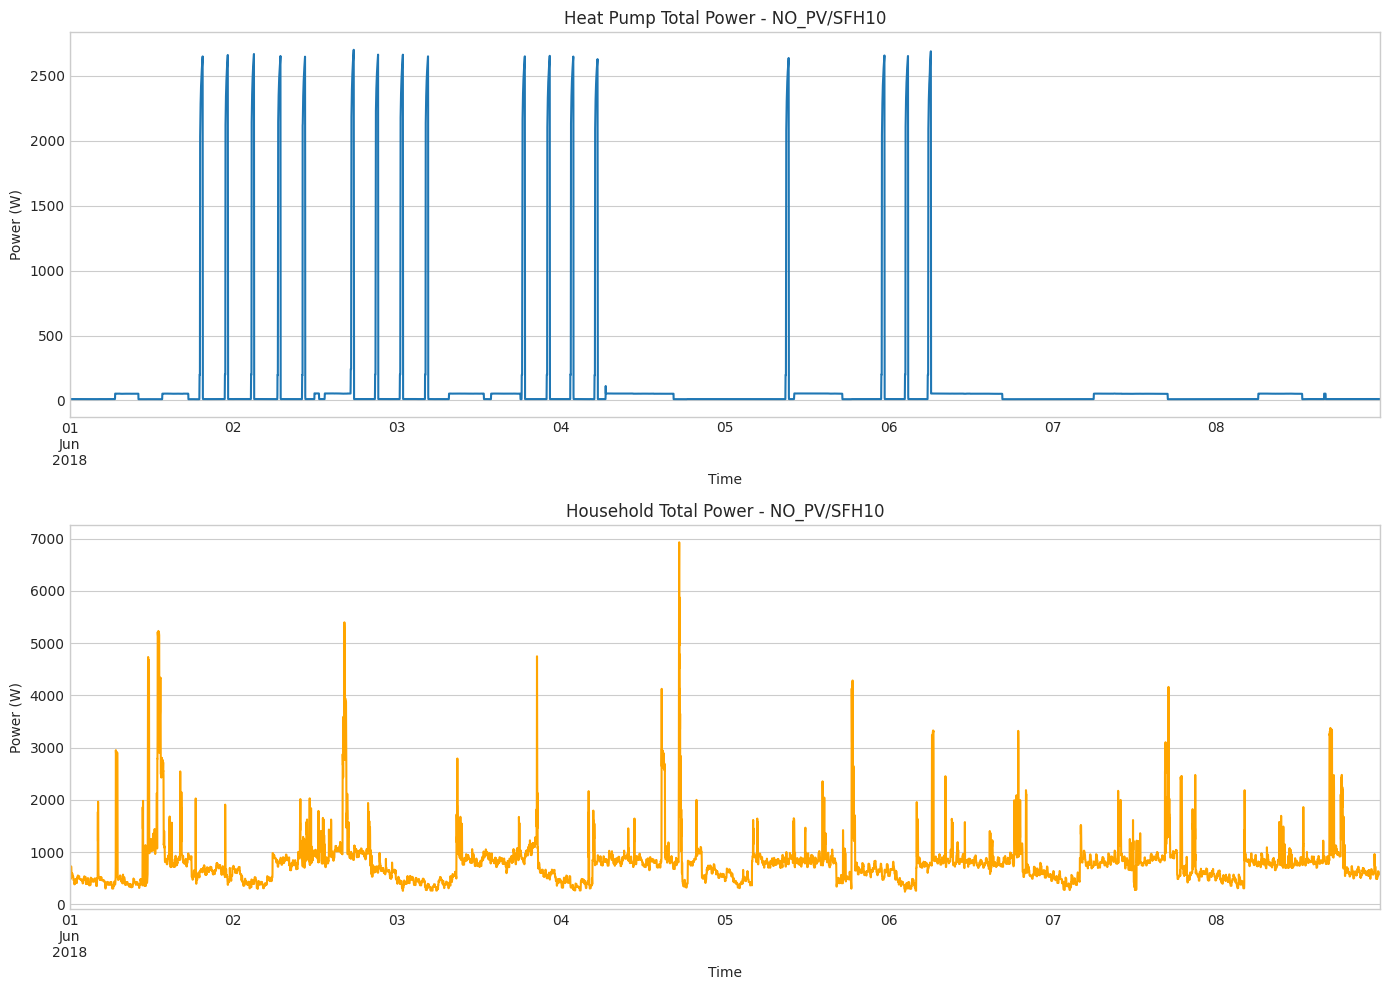

In [111]:
# Plot a week of heat pump total power (if P_TOT exists)
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Sample one week
week_start = '2018-06-01'
week_end = '2018-06-08'

# Heat pump power
if 'P_TOT' in df_heatpump.columns:
    ax1 = axes[0]
    df_heatpump.loc[week_start:week_end, 'P_TOT'].plot(ax=ax1)
    ax1.set_title(f'Heat Pump Total Power - {sample_building}')
    ax1.set_ylabel('Power (W)')
    ax1.set_xlabel('Time')

# Household power
if 'P_TOT' in df_household.columns:
    ax2 = axes[1]
    df_household.loc[week_start:week_end, 'P_TOT'].plot(ax=ax2, color='orange')
    ax2.set_title(f'Household Total Power - {sample_building}')
    ax2.set_ylabel('Power (W)')
    ax2.set_xlabel('Time')

plt.tight_layout()
plt.show()

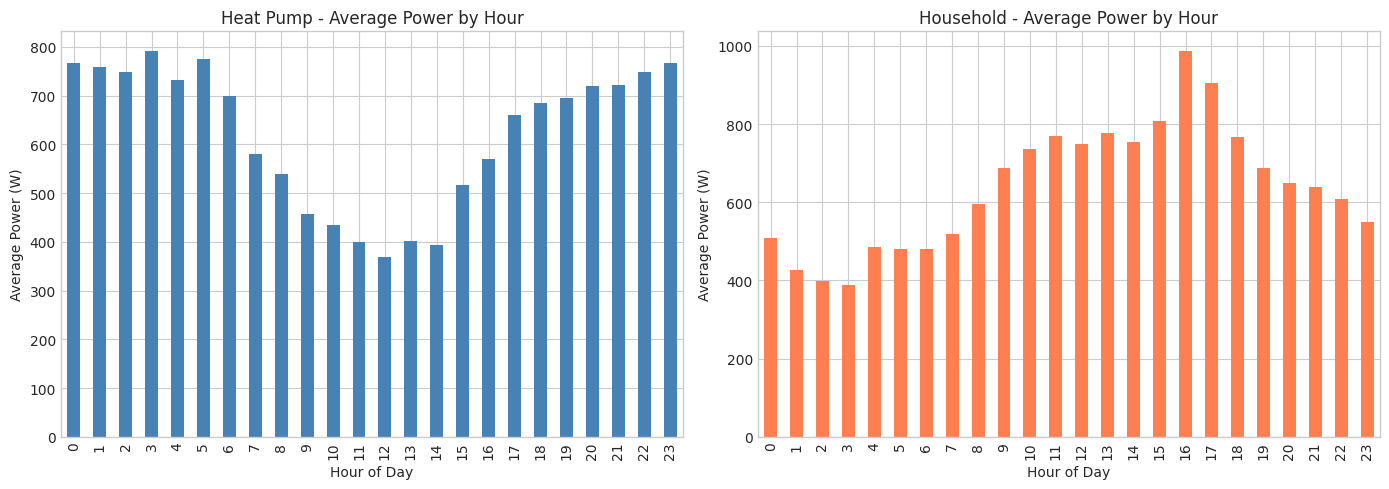

In [112]:
# Plot daily average power profile
if 'P_TOT' in df_heatpump.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Heat pump daily profile
    hp_hourly = df_heatpump['P_TOT'].groupby(df_heatpump.index.hour).mean()
    hp_hourly.plot(kind='bar', ax=axes[0], color='steelblue')
    axes[0].set_title('Heat Pump - Average Power by Hour')
    axes[0].set_xlabel('Hour of Day')
    axes[0].set_ylabel('Average Power (W)')
    
    # Household daily profile
    if 'P_TOT' in df_household.columns:
        hh_hourly = df_household['P_TOT'].groupby(df_household.index.hour).mean()
        hh_hourly.plot(kind='bar', ax=axes[1], color='coral')
        axes[1].set_title('Household - Average Power by Hour')
        axes[1].set_xlabel('Hour of Day')
        axes[1].set_ylabel('Average Power (W)')
    
    plt.tight_layout()
    plt.show()

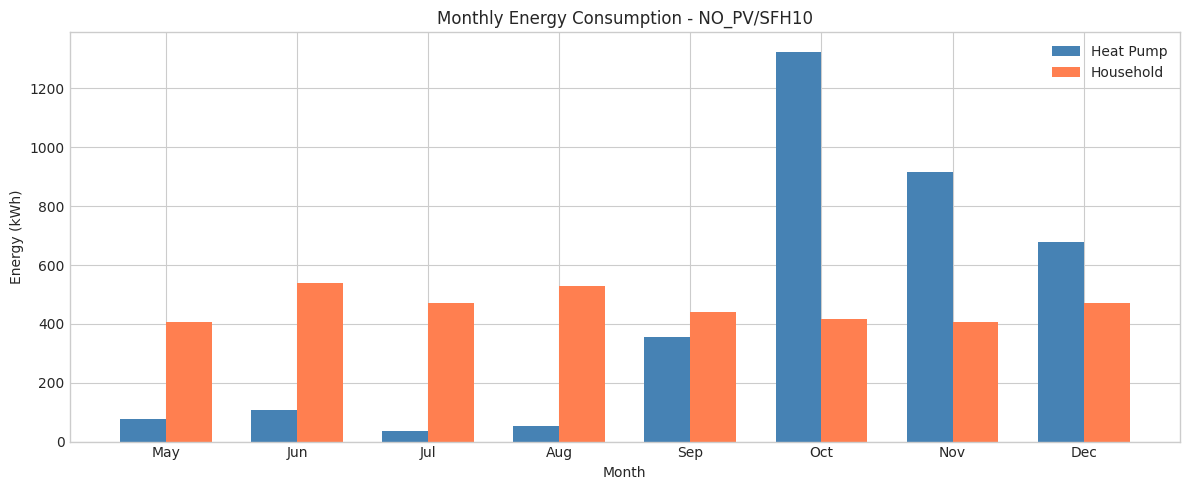

In [113]:
# Monthly energy consumption
if 'P_TOT' in df_heatpump.columns:
    fig, ax = plt.subplots(figsize=(12, 5))
    
    # Resample to monthly and convert to kWh (assuming 1-minute data)
    hp_monthly = df_heatpump['P_TOT'].resample('ME').sum() / 1000 / 60  # kWh
    hh_monthly = df_household['P_TOT'].resample('ME').sum() / 1000 / 60 if 'P_TOT' in df_household.columns else None
    
    x = np.arange(len(hp_monthly))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, hp_monthly.values, width, label='Heat Pump', color='steelblue')
    if hh_monthly is not None:
        bars2 = ax.bar(x + width/2, hh_monthly.values, width, label='Household', color='coral')
    
    ax.set_xlabel('Month')
    ax.set_ylabel('Energy (kWh)')
    ax.set_title(f'Monthly Energy Consumption - {sample_building}')
    ax.set_xticks(x)
    ax.set_xticklabels(hp_monthly.index.strftime('%b'))
    ax.legend()
    
    plt.tight_layout()
    plt.show()

## 7. Distribution Analysis

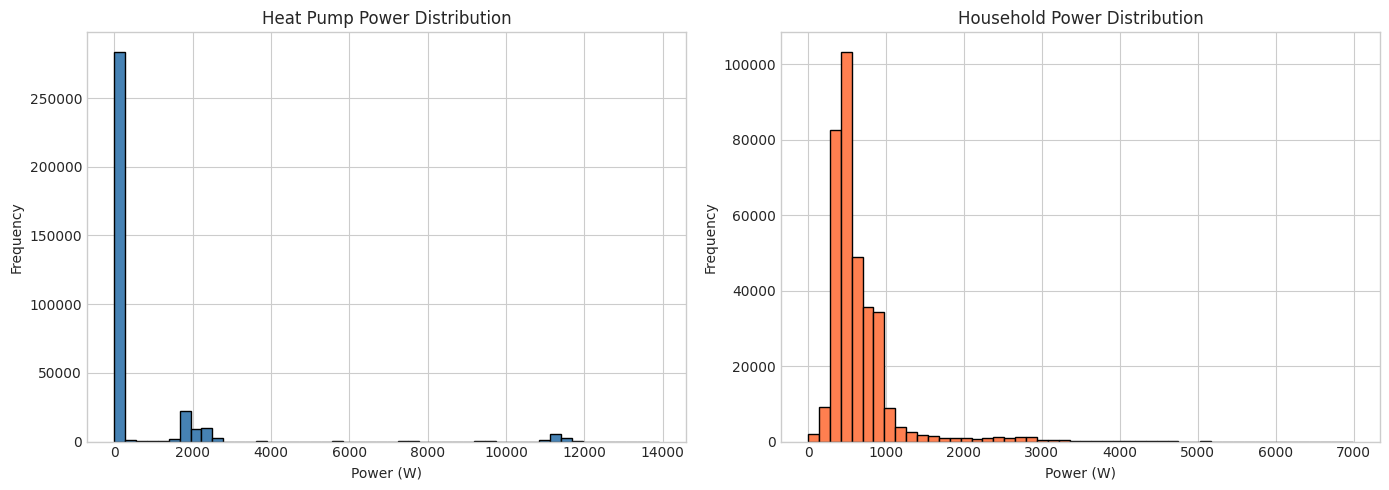

In [114]:
# Distribution of power values
if 'P_TOT' in df_heatpump.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Heat pump power distribution
    df_heatpump['P_TOT'].dropna().hist(bins=50, ax=axes[0], color='steelblue', edgecolor='black')
    axes[0].set_title('Heat Pump Power Distribution')
    axes[0].set_xlabel('Power (W)')
    axes[0].set_ylabel('Frequency')
    
    # Household power distribution
    if 'P_TOT' in df_household.columns:
        df_household['P_TOT'].dropna().hist(bins=50, ax=axes[1], color='coral', edgecolor='black')
        axes[1].set_title('Household Power Distribution')
        axes[1].set_xlabel('Power (W)')
        axes[1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

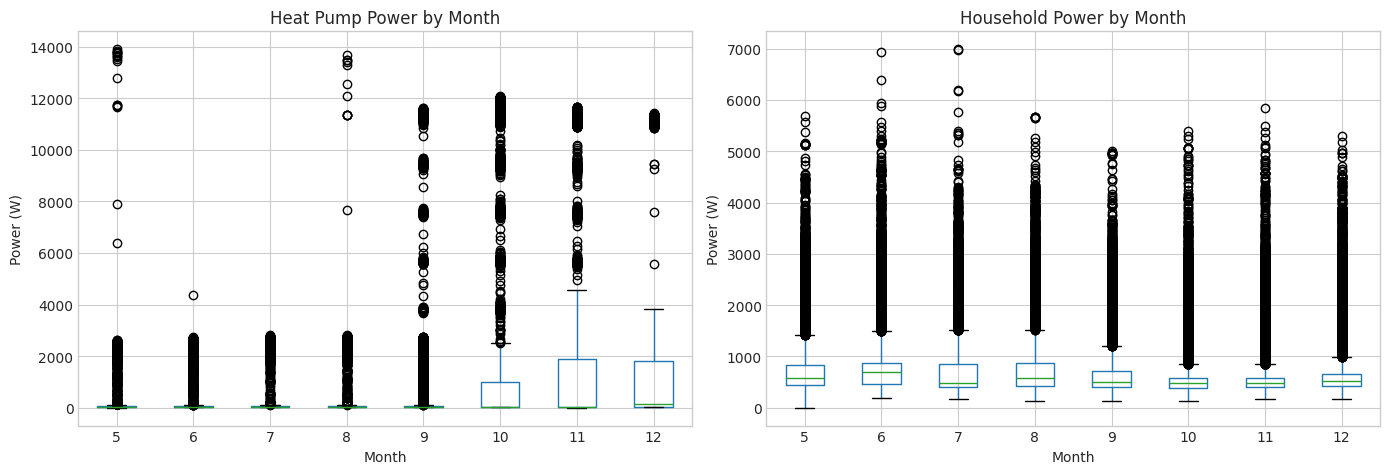

In [115]:
# Box plot by month
if 'P_TOT' in df_heatpump.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    df_hp_monthly = df_heatpump[['P_TOT']].copy()
    df_hp_monthly['month'] = df_hp_monthly.index.month
    
    df_hp_monthly.boxplot(column='P_TOT', by='month', ax=axes[0])
    axes[0].set_title('Heat Pump Power by Month')
    axes[0].set_xlabel('Month')
    axes[0].set_ylabel('Power (W)')
    plt.suptitle('')  # Remove automatic title
    
    if 'P_TOT' in df_household.columns:
        df_hh_monthly = df_household[['P_TOT']].copy()
        df_hh_monthly['month'] = df_hh_monthly.index.month
        
        df_hh_monthly.boxplot(column='P_TOT', by='month', ax=axes[1])
        axes[1].set_title('Household Power by Month')
        axes[1].set_xlabel('Month')
        axes[1].set_ylabel('Power (W)')
        plt.suptitle('')
    
    plt.tight_layout()
    plt.show()

## 8. Correlation Analysis

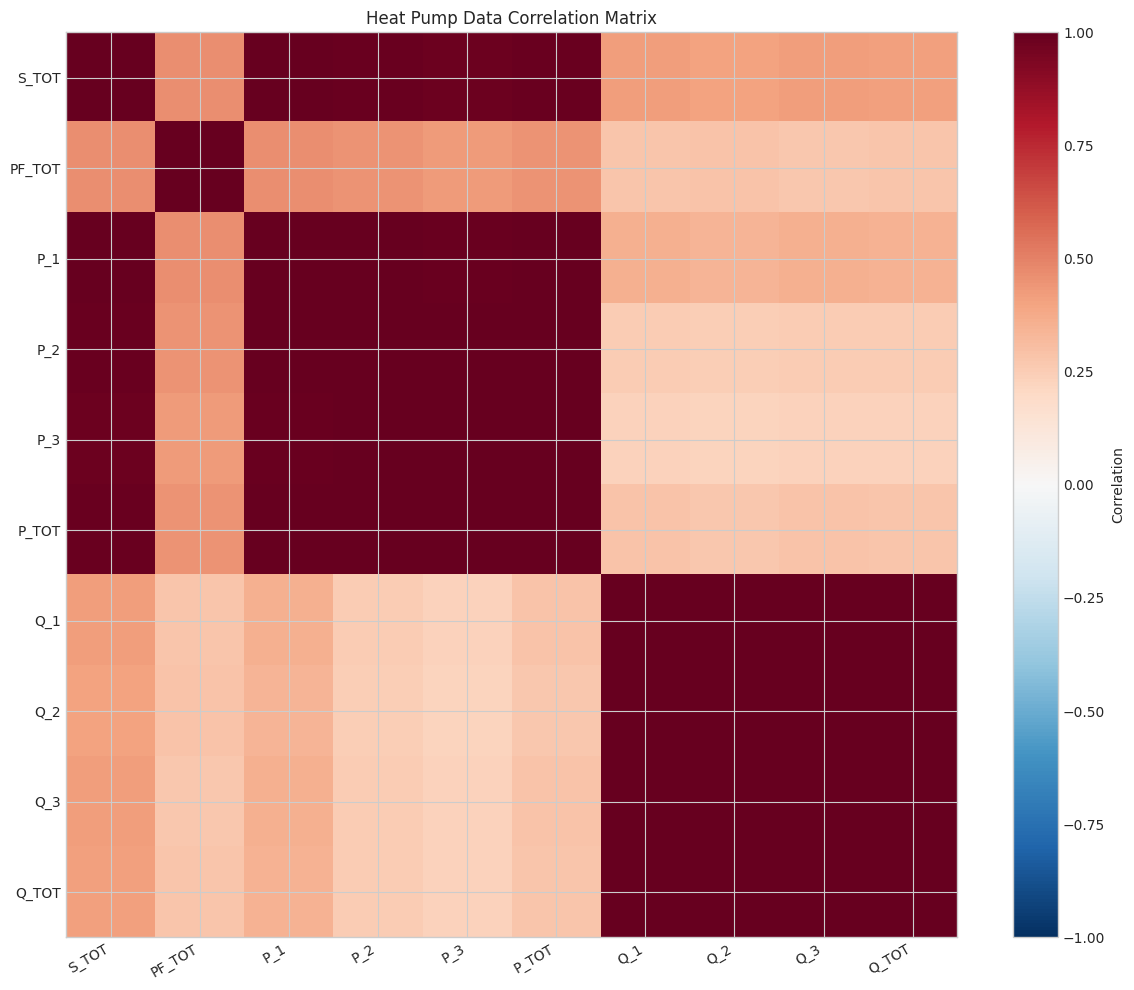

In [116]:
# Correlation matrix for heat pump data
numeric_cols_hp = df_heatpump.select_dtypes(include=[np.number]).columns
if len(numeric_cols_hp) > 1:
    corr_hp = df_heatpump[numeric_cols_hp].corr()
    
    fig, ax = plt.subplots(figsize=(12, 10))
    im = ax.imshow(corr_hp, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
    
    ax.set_xticks(range(len(numeric_cols_hp)))
    ax.set_yticks(range(len(numeric_cols_hp)))
    ax.set_xticklabels(numeric_cols_hp, rotation=30, ha='right')
    ax.set_yticklabels(numeric_cols_hp)
    
    plt.colorbar(im, ax=ax, label='Correlation')
    ax.set_title('Heat Pump Data Correlation Matrix')
    
    plt.tight_layout()
    plt.show()

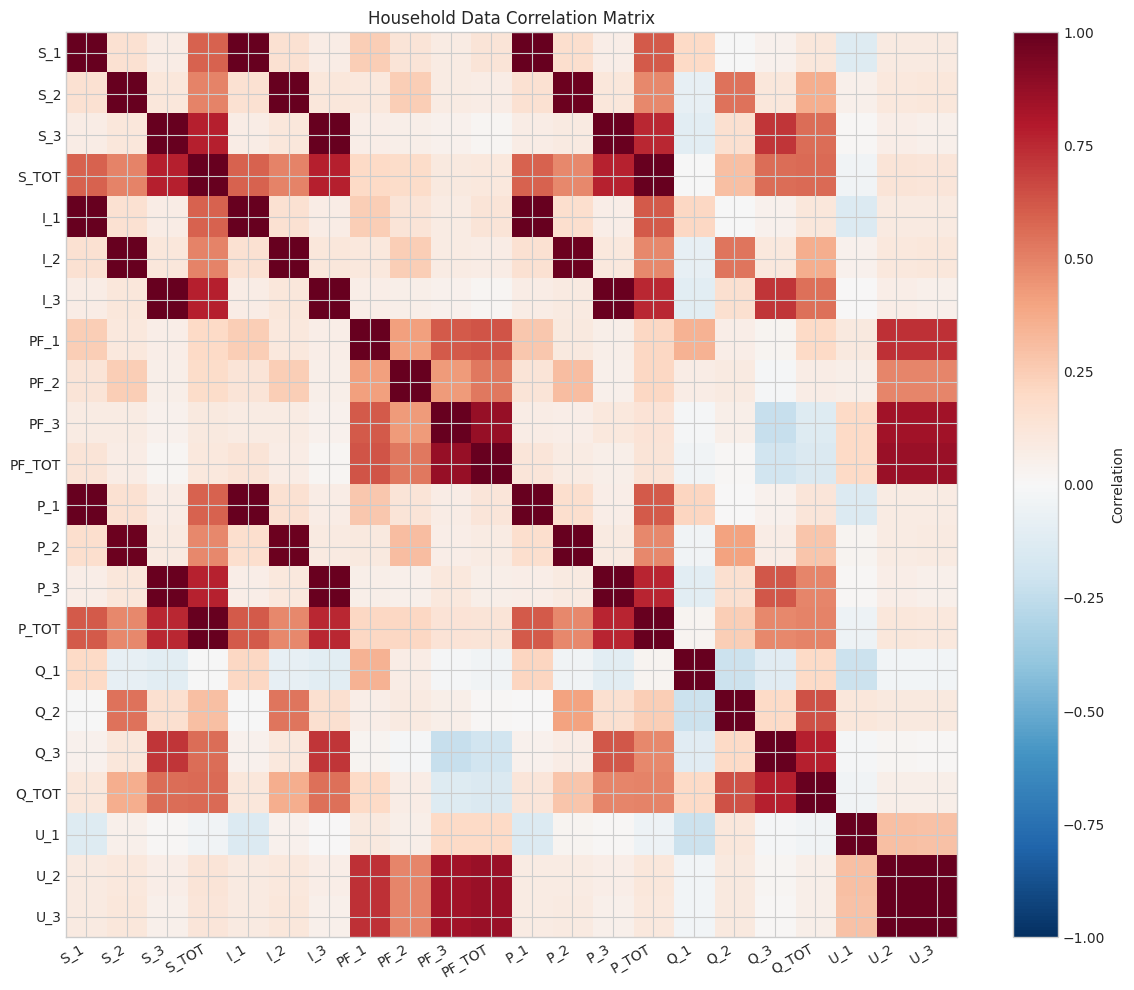

In [117]:
# Correlation matrix for household data
numeric_cols_hh = df_household.select_dtypes(include=[np.number]).columns
if len(numeric_cols_hh) > 1:
    corr_hh = df_household[numeric_cols_hh].corr()
    
    fig, ax = plt.subplots(figsize=(12, 10))
    im = ax.imshow(corr_hh, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
    
    ax.set_xticks(range(len(numeric_cols_hh)))
    ax.set_yticks(range(len(numeric_cols_hh)))
    ax.set_xticklabels(numeric_cols_hh, rotation=30, ha='right')
    ax.set_yticklabels(numeric_cols_hh)
    
    plt.colorbar(im, ax=ax, label='Correlation')
    ax.set_title('Household Data Correlation Matrix')
    
    plt.tight_layout()
    plt.show()

## 9. Compare Multiple Buildings

In [118]:
# Load data from multiple buildings for comparison
store = pd.HDFStore(str(hdf5_path), 'r')

# Get list of all buildings
no_pv_buildings = sorted(set([k.split('/')[2] for k in store.keys() if 'NO_PV' in k]))
with_pv_buildings = sorted(set([k.split('/')[2] for k in store.keys() if 'WITH_PV' in k]))

print(f"Buildings without PV ({len(no_pv_buildings)}): {no_pv_buildings}")
print(f"Buildings with PV ({len(with_pv_buildings)}): {with_pv_buildings}")

store.close()

Buildings without PV (34): ['SFH10', 'SFH11', 'SFH12', 'SFH14', 'SFH16', 'SFH17', 'SFH18', 'SFH19', 'SFH20', 'SFH21', 'SFH22', 'SFH23', 'SFH24', 'SFH25', 'SFH27', 'SFH28', 'SFH29', 'SFH3', 'SFH30', 'SFH31', 'SFH32', 'SFH34', 'SFH35', 'SFH36', 'SFH37', 'SFH38', 'SFH39', 'SFH4', 'SFH40', 'SFH5', 'SFH6', 'SFH7', 'SFH8', 'SFH9']
Buildings with PV (4): ['SFH13', 'SFH15', 'SFH26', 'SFH33']


In [119]:
# Calculate total energy consumption for each building
store = pd.HDFStore(str(hdf5_path), 'r')

energy_summary = []

# Sample a few buildings (to keep runtime reasonable)
sample_buildings = no_pv_buildings[:5] + with_pv_buildings[:3]

for building in sample_buildings:
    category = 'NO_PV' if building in no_pv_buildings else 'WITH_PV'
    
    try:
        hp_key = f'/{category}/{building}/HEATPUMP'
        hh_key = f'/{category}/{building}/HOUSEHOLD'
        
        df_hp = store[hp_key]
        df_hh = store[hh_key]
        
        # Convert index to datetime
        if not isinstance(df_hp.index, pd.DatetimeIndex):
            df_hp.index = pd.to_datetime(df_hp.index, unit='s')
        if not isinstance(df_hh.index, pd.DatetimeIndex):
            df_hh.index = pd.to_datetime(df_hh.index, unit='s')
        
        # Calculate annual energy (kWh)
        hp_energy = df_hp['P_TOT'].sum() / 1000 / 60 if 'P_TOT' in df_hp.columns else np.nan
        hh_energy = df_hh['P_TOT'].sum() / 1000 / 60 if 'P_TOT' in df_hh.columns else np.nan
        
        energy_summary.append({
            'building': building,
            'category': category,
            'hp_energy_kwh': hp_energy,
            'hh_energy_kwh': hh_energy,
            'total_energy_kwh': hp_energy + hh_energy if not np.isnan(hp_energy) and not np.isnan(hh_energy) else np.nan
        })
    except Exception as e:
        print(f"Error processing {building}: {e}")

store.close()

energy_df = pd.DataFrame(energy_summary)
print("Annual Energy Consumption (kWh):")
energy_df

Annual Energy Consumption (kWh):


,building,category,hp_energy_kwh,hh_energy_kwh,total_energy_kwh
0,SFH10,NO_PV,3548.044467,3679.909847,7227.954314
1,SFH11,NO_PV,2135.530896,1790.903843,3926.434739
2,SFH12,NO_PV,1109.441187,1679.575822,2789.017008
3,SFH14,NO_PV,4864.466084,1450.707147,6315.173231
4,SFH16,NO_PV,937.899746,1459.494565,2397.394311
5,SFH13,WITH_PV,778.756724,1801.328762,2580.085486
6,SFH15,WITH_PV,1751.532132,698.109378,2449.641510
7,SFH26,WITH_PV,881.442234,1592.291250,2473.733484


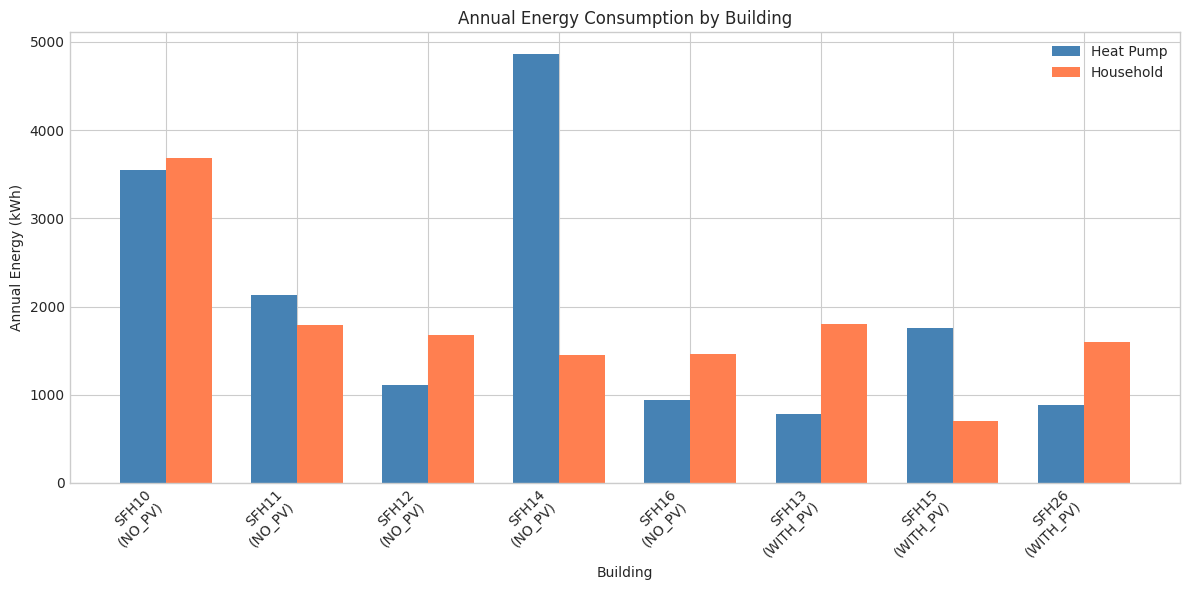

In [120]:
# Plot energy comparison
if len(energy_df) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(len(energy_df))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, energy_df['hp_energy_kwh'], width, label='Heat Pump', color='steelblue')
    bars2 = ax.bar(x + width/2, energy_df['hh_energy_kwh'], width, label='Household', color='coral')
    
    ax.set_xlabel('Building')
    ax.set_ylabel('Annual Energy (kWh)')
    ax.set_title('Annual Energy Consumption by Building')
    ax.set_xticks(x)
    ax.set_xticklabels([f"{row['building']}\n({row['category']})" for _, row in energy_df.iterrows()], rotation=45, ha='right')
    ax.legend()
    
    plt.tight_layout()
    plt.show()

## 10. Explore MISC Data (Transformer & PV)

In [125]:
# Load MISC data
store = pd.HDFStore(str(hdf5_path), 'r')

misc_keys = [k for k in store.keys() if 'MISC' in k]
print("MISC keys:", misc_keys)

MISC keys: ['/MISC/PV1/PV/INVERTER/EAST', '/MISC/PV1/PV/INVERTER/SOUTH', '/MISC/PV1/PV/INVERTER/WEST', '/MISC/ES1/TRANSFORMER']


In [126]:
# Separate transformer and inverter keys
transformer_keys = [k for k in misc_keys if 'TRANSFORMER' in k]
inverter_keys = [k for k in misc_keys if 'INVERTER' in k]

print(f"\nTransformer keys ({len(transformer_keys)}): {transformer_keys}")
print(f"Inverter keys ({len(inverter_keys)}): {inverter_keys}")

# Load transformer data
df_transformers = {}
for key in transformer_keys:
    try:
        df = store[key]
        name = key.split('/')[-2]  # e.g., 'ES1'
        df_transformers[name] = df
        print(f"\nTransformer '{name}' data shape: {df.shape}")
        print(f"Transformer '{name}' columns: {list(df.columns)}")
    except Exception as e:
        print(f"Error loading transformer {key}: {e}")

# Load PV inverter data
df_inverters = {}
for key in inverter_keys:
    try:
        df = store[key]
        orientation = key.split('/')[-1]  # e.g., 'EAST', 'SOUTH', 'WEST'
        df_inverters[orientation] = df
        print(f"\nInverter '{orientation}' data shape: {df.shape}")
        print(f"Inverter '{orientation}' columns: {list(df.columns)}")
    except Exception as e:
        print(f"Error loading inverter {key}: {e}")

store.close()


Transformer keys (1): ['/MISC/ES1/TRANSFORMER']
Inverter keys (3): ['/MISC/PV1/PV/INVERTER/EAST', '/MISC/PV1/PV/INVERTER/SOUTH', '/MISC/PV1/PV/INVERTER/WEST']

Transformer 'ES1' data shape: (525600, 22)
Transformer 'ES1' columns: ['S_1', 'S_2', 'S_3', 'S_TOT', 'I_1', 'I_2', 'I_3', 'PF_1', 'PF_2', 'PF_3', 'PF_TOT', 'P_1', 'P_2', 'P_3', 'P_TOT', 'Q_1', 'Q_2', 'Q_3', 'Q_TOT', 'U_1', 'U_2', 'U_3']

Inverter 'EAST' data shape: (525600, 20)
Inverter 'EAST' columns: ['S_TOT', 'I_DC1', 'I_DC2', 'I_1', 'I_2', 'I_3', 'I_TOT', 'E_DC1', 'E_DC2', 'E_TOT', 'P_DC1', 'P_DC2', 'PF_TOT', 'P_TOT', 'Q_TOT', 'U_DC1', 'U_DC2', 'U_1', 'U_2', 'U_3']

Inverter 'SOUTH' data shape: (525600, 14)
Inverter 'SOUTH' columns: ['S_TOT', 'I_DC1', 'I_1', 'I_2', 'I_3', 'I_TOT', 'E_TOT', 'PF_TOT', 'P_TOT', 'Q_TOT', 'U_DC1', 'U_1', 'U_2', 'U_3']

Inverter 'WEST' data shape: (525600, 20)
Inverter 'WEST' columns: ['S_TOT', 'I_DC1', 'I_DC2', 'I_1', 'I_2', 'I_3', 'I_TOT', 'E_DC1', 'E_DC2', 'E_TOT', 'P_DC1', 'P_DC2', 'PF_TOT', 

In [122]:
# Preview transformer data
for name, df in df_transformers.items():
    # Convert index
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index, unit='s')
        df_transformers[name] = df  # Update dict with converted index
    
    print(f"\n{'='*60}")
    print(f"Transformer '{name}' data preview:")
    print(f"{'='*60}")
    display(df.dropna().head())
    print(f"\nTransformer '{name}' statistics:")
    display(df.describe())


Transformer 'ES1' data preview:


,S_1,S_2,S_3,S_TOT,I_1,I_2,I_3,PF_1,PF_2,PF_3,PF_TOT,P_1,P_2,P_3,P_TOT,Q_1,Q_2,Q_3,Q_TOT,U_1,U_2,U_3
2018-04-11 15:37:00,8457.490234,8718.099609,7499.310059,24674.900391,36.779999,37.799999,32.599998,0.954,0.949,0.944,0.949,8070.25,8268.759766,7078.740234,23417.75,857.590027,1524.609985,332.73999,2714.939941,230.0,230.699997,230.0
2018-04-11 15:38:00,8457.490234,8718.099609,7499.310059,24674.900391,36.779999,37.799999,32.599998,0.954,0.949,0.944,0.949,8070.25,8268.759766,7078.740234,23417.75,857.590027,1524.609985,332.73999,2714.939941,230.0,230.699997,230.0
2018-04-11 15:39:00,8457.490234,8718.099609,7499.310059,24674.900391,36.779999,37.799999,32.599998,0.954,0.949,0.944,0.949,8070.25,8268.759766,7078.740234,23417.75,857.590027,1524.609985,332.73999,2714.939941,230.0,230.699997,230.0
2018-04-11 15:40:00,8457.490234,8718.099609,7499.310059,24674.900391,36.779999,37.799999,32.599998,0.954,0.949,0.944,0.949,8070.25,8268.759766,7078.740234,23417.75,857.590027,1524.609985,332.73999,2714.939941,230.0,230.699997,230.0
2018-04-11 15:41:00,8457.490234,8718.099609,7499.310059,24674.900391,36.779999,37.799999,32.599998,0.954,0.949,0.944,0.949,8070.25,8268.759766,7078.740234,23417.75,857.590027,1524.609985,332.73999,2714.939941,230.0,230.699997,230.0



Transformer 'ES1' statistics:


,S_1,S_2,S_3,S_TOT,I_1,I_2,I_3,PF_1,PF_2,PF_3,PF_TOT,P_1,P_2,P_3,P_TOT,Q_1,Q_2,Q_3,Q_TOT,U_1,U_2,U_3
count,380663.000000,380663.000000,380663.000000,380663.000000,380663.000000,380663.000000,380663.000000,380663.000000,380663.000000,380663.000000,380663.000000,380663.000000,380663.000000,380663.000000,380663.000000,380663.000000,380663.000000,380663.000000,380663.000000,380663.000000,380663.000000,380663.000000
mean,16539.899382,15994.214639,16728.906123,49263.047356,71.600700,69.100761,72.349378,0.919238,0.920264,0.887050,0.937034,15630.363705,14992.721043,15721.397954,46344.543869,3664.522303,4459.770162,3693.527460,11817.828226,231.197484,231.688715,231.434622
std,11990.573436,12032.324962,11947.593819,35610.025413,52.045938,52.117379,51.820842,0.166980,0.110439,0.274031,0.111310,11481.491671,11338.098364,11533.751539,33898.096841,4584.128476,4628.020163,4734.387959,13875.806849,1.365837,1.432423,1.350836
min,1851.780853,1681.842489,1606.871653,6411.465861,7.979167,7.275833,6.870833,-0.931750,-0.742083,-0.944500,-0.899667,-5340.119995,-2078.514150,-6018.322469,-6571.715007,-3623.264994,-1077.462499,-4867.434123,-2856.564148,225.883334,226.799997,226.316667
25%,8149.410787,7590.952474,8475.384216,24612.434001,35.198333,32.710000,36.575417,0.934833,0.921500,0.934000,0.935583,7770.041646,7180.715047,8147.005025,23417.750000,445.286247,1255.543757,335.568748,2148.718343,230.216667,230.691666,230.466663
50%,11963.211751,10944.258301,12456.625163,34844.897624,51.727500,47.230000,53.753334,0.955500,0.947667,0.960750,0.960917,11543.505859,10471.216878,12093.083333,33615.242350,1569.597504,2284.144989,1574.334157,5094.728312,231.208333,231.691667,231.449997
75%,21599.983073,21242.653483,22346.083740,64851.391764,93.427084,91.767917,96.599584,0.968750,0.962750,0.974500,0.980250,20594.719076,20013.548055,21288.725098,61544.865234,5701.116659,6440.406677,5955.962545,18064.974569,232.133334,232.675002,232.366666
max,72450.082031,73967.914714,77717.200521,221693.634115,318.428329,320.820000,341.198334,0.995833,0.994583,0.996333,1.000000,68609.215495,70559.319010,73969.468750,209304.048177,29635.057780,30083.883626,30486.658366,90205.597656,238.833331,239.550001,238.941668


In [123]:
# Preview PV inverter data
for orientation, df in df_inverters.items():
    # Convert index
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index, unit='s')
        df_inverters[orientation] = df  # Update dict with converted index
    
    print(f"\n{'='*60}")
    print(f"PV Inverter '{orientation}' data preview:")
    print(f"{'='*60}")
    display(df.dropna().head())
    print(f"\nPV Inverter '{orientation}' statistics:")
    display(df.describe())


PV Inverter 'EAST' data preview:


,S_TOT,I_DC1,I_DC2,I_1,I_2,I_3,I_TOT,E_DC1,E_DC2,E_TOT,P_DC1,P_DC2,PF_TOT,P_TOT,Q_TOT,U_DC1,U_DC2,U_1,U_2,U_3
2018-03-06 13:23:00,8348.0,10.61,3.5,12.19,12.21,12.55,36.950001,40900.117188,12388.631836,53288.742188,66.580002,20.17,1.0,8348.0,0.0,627.599976,576.5,226.600006,227.0,228.199997
2018-03-06 13:24:00,8348.0,10.61,3.5,12.19,12.21,12.55,36.950001,40900.117188,12388.631836,53288.742188,66.580002,20.17,1.0,8348.0,0.0,627.599976,576.5,226.600006,227.0,228.199997
2018-03-06 13:25:00,8348.0,10.61,3.5,12.19,12.21,12.55,36.950001,40900.117188,12388.631836,53288.742188,66.580002,20.17,1.0,8348.0,0.0,627.599976,576.5,226.600006,227.0,228.199997
2018-03-06 13:26:00,8348.0,10.61,3.5,12.19,12.21,12.55,36.950001,40900.117188,12388.631836,53288.742188,66.580002,20.17,1.0,8348.0,0.0,627.599976,576.5,226.600006,227.0,228.199997
2018-03-06 13:27:00,8348.0,10.61,3.5,12.19,12.21,12.55,36.950001,40900.117188,12388.631836,53288.742188,66.580002,20.17,1.0,8348.0,0.0,627.599976,576.5,226.600006,227.0,228.199997



PV Inverter 'EAST' statistics:


,S_TOT,I_DC1,I_DC2,I_1,I_2,I_3,I_TOT,E_DC1,E_DC2,E_TOT,P_DC1,P_DC2,PF_TOT,P_TOT,Q_TOT,U_DC1,U_DC2,U_1,U_2,U_3
count,432637.000000,432637.000000,432637.000000,432637.000000,432637.000000,432637.000000,432637.000000,432637.000000,432637.000000,432637.000000,432637.000000,432637.000000,432637.000000,432637.000000,432637.000000,432637.000000,432637.000000,432637.000000,432637.000000,432637.000000
mean,2392.879855,3.473339,1.088868,3.493516,3.536658,3.544011,10.574161,53127.967903,13643.024481,62354.432287,130.105350,36.929500,0.478885,2392.915503,1.766388,318.609020,286.890803,124.145116,124.463324,124.237129
std,3768.320298,5.599825,1.744609,5.411163,5.498433,5.471927,16.381041,8865.896208,3301.604914,5926.350146,168.335054,48.748767,0.441280,3768.297640,5.492635,290.283964,262.383154,114.345048,114.638842,114.428540
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40255.964844,0.000000,50.591523,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,45816.306641,12832.362142,56832.238281,0.000000,0.000000,0.000000,0.000000,0.000000,0.309588,0.000000,0.000000,0.000000,0.000000
50%,161.504745,0.260000,0.073333,0.548333,0.400000,0.628333,1.570000,52066.505859,14422.421387,63719.374349,73.203332,20.433334,0.573971,161.666667,0.000000,523.116674,474.933334,227.183337,227.683334,227.633334
75%,3472.003581,4.883333,1.545000,5.033333,5.146667,5.090000,15.270000,59769.808594,15837.625000,68176.921875,215.488335,60.723333,1.000000,3472.166667,0.500000,598.416677,538.299998,229.933339,230.516670,230.066668
max,19972.000000,32.834999,8.810000,28.434999,28.353333,28.381666,84.903332,69086.351562,16205.766602,69086.351562,654.279989,400.713333,1.000000,19972.000000,1025.000000,653.483337,628.333333,236.416669,237.183332,236.683334



PV Inverter 'SOUTH' data preview:


,S_TOT,I_DC1,I_1,I_2,I_3,I_TOT,E_TOT,PF_TOT,P_TOT,Q_TOT,U_DC1,U_1,U_2,U_3
2018-03-06 13:23:00,9392.0,17.15,13.87,13.91,14.26,42.049999,48134.550781,1.0,9392.0,0.0,592.909973,224.199997,224.410004,224.910004
2018-03-06 13:24:00,9392.0,17.15,13.87,13.91,14.26,42.049999,48134.550781,1.0,9392.0,0.0,592.909973,224.199997,224.410004,224.910004
2018-03-06 13:25:00,9392.0,17.15,13.87,13.91,14.26,42.049999,48134.550781,1.0,9392.0,0.0,592.909973,224.199997,224.410004,224.910004
2018-03-06 13:26:00,9392.0,17.15,13.87,13.91,14.26,42.049999,48134.550781,1.0,9392.0,0.0,592.909973,224.199997,224.410004,224.910004
2018-03-06 13:27:00,9392.0,17.15,13.87,13.91,14.26,42.049999,48134.550781,1.0,9392.0,0.0,592.909973,224.199997,224.410004,224.910004



PV Inverter 'SOUTH' statistics:


,S_TOT,I_DC1,I_1,I_2,I_3,I_TOT,E_TOT,PF_TOT,P_TOT,Q_TOT,U_DC1,U_1,U_2,U_3
count,432637.000000,432637.000000,432637.000000,432637.000000,432637.000000,432637.000000,432637.000000,432637.000000,432637.000000,432637.000000,432637.000000,432637.000000,432637.000000,432637.000000
mean,2230.240024,4.231327,3.285790,3.290156,3.479893,10.054402,57245.763420,0.493238,2230.198365,1.607338,308.441148,119.809594,119.746001,119.912874
std,3603.797569,6.959811,5.285239,5.288909,5.381821,15.954398,5248.351133,0.396050,3603.612705,3.709220,284.150238,111.962411,111.903114,112.057272
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24649.717448,-0.996520,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,52544.813802,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,105.175001,0.238333,0.250000,0.346667,0.770000,1.353333,58046.830078,0.624070,105.333333,0.000000,516.023321,222.086665,221.971667,222.540001
75%,3019.666667,5.491667,4.456667,4.420000,4.745000,13.618333,62586.742188,0.999800,3019.666667,1.000000,578.023315,224.891668,224.774999,225.073334
max,15257.500000,31.170000,21.690001,21.690001,21.690001,65.099998,63828.617188,1.000000,15243.166667,121.000000,734.153330,230.960002,231.154999,231.525002



PV Inverter 'WEST' data preview:


,S_TOT,I_DC1,I_DC2,I_1,I_2,I_3,I_TOT,E_DC1,E_DC2,E_TOT,P_DC1,P_DC2,PF_TOT,P_TOT,Q_TOT,U_DC1,U_DC2,U_1,U_2,U_3
2018-03-06 13:23:00,5607.0,6.96,2.44,8.179999,8.36,8.29,24.829998,39925.710938,12241.810547,52167.523438,442.51001,141.080002,1.0,5607.0,0.0,635.799988,578.200012,226.400009,227.100006,228.0
2018-03-06 13:24:00,5607.0,6.96,2.44,8.179999,8.36,8.29,24.829998,39925.710938,12241.810547,52167.523438,442.51001,141.080002,1.0,5607.0,0.0,635.799988,578.200012,226.400009,227.100006,228.0
2018-03-06 13:25:00,5607.0,6.96,2.44,8.179999,8.36,8.29,24.829998,39925.710938,12241.810547,52167.523438,442.51001,141.080002,1.0,5607.0,0.0,635.799988,578.200012,226.400009,227.100006,228.0
2018-03-06 13:26:00,5607.0,6.96,2.44,8.179999,8.36,8.29,24.829998,39925.710938,12241.810547,52167.523438,442.51001,141.080002,1.0,5607.0,0.0,635.799988,578.200012,226.400009,227.100006,228.0
2018-03-06 13:27:00,5607.0,6.96,2.44,8.179999,8.36,8.29,24.829998,39925.710938,12241.810547,52167.523438,442.51001,141.080002,1.0,5607.0,0.0,635.799988,578.200012,226.400009,227.100006,228.0



PV Inverter 'WEST' statistics:


,S_TOT,I_DC1,I_DC2,I_1,I_2,I_3,I_TOT,E_DC1,E_DC2,E_TOT,P_DC1,P_DC2,PF_TOT,P_TOT,Q_TOT,U_DC1,U_DC2,U_1,U_2,U_3
count,432637.000000,432637.000000,432637.000000,432637.000000,432637.000000,432637.000000,432637.000000,432637.000000,432637.000000,432637.000000,432637.000000,432637.000000,432637.000000,432637.000000,432637.000000,432637.000000,432637.000000,432637.000000,432637.000000,432637.000000
mean,2433.823295,3.446643,1.102210,3.519642,3.517082,3.709292,10.746172,53672.188454,14558.191673,63436.950980,133.298468,38.047913,0.509554,2433.824272,1.806079,319.115268,285.803828,124.513631,124.649361,124.642042
std,3826.831032,5.532928,1.768419,5.509979,5.508295,5.612158,16.629400,8747.483994,1917.900845,5983.365128,170.420231,49.351472,0.391034,3826.794003,4.263382,289.697316,260.656808,114.392125,114.517438,114.509335
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39925.710938,0.000000,7013.962891,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,46688.437500,13408.780273,58037.093099,0.000000,0.000000,0.000002,0.000000,0.000000,0.535066,0.206150,0.000000,0.000000,0.000000
50%,175.170832,0.270000,0.078333,0.336667,0.408333,0.820000,1.556667,52616.035156,14971.278809,64858.052083,74.826667,21.100000,0.666663,175.166667,0.000000,523.116669,464.916667,227.316671,227.466670,227.783338
75%,3590.833333,4.906667,1.583333,5.188333,5.146667,5.468333,15.801667,59571.858113,16081.905273,69386.648438,227.121666,64.199998,0.999992,3590.833333,1.000000,598.250000,536.783325,230.033338,230.283335,230.233332
max,20166.520182,31.151667,8.908333,28.586666,28.718333,28.268333,86.399999,70358.164062,16326.989258,70358.156250,654.221670,333.441666,1.000000,20166.500000,398.666667,653.699992,646.249990,236.650004,236.866671,236.966675


## 11. Summary

In [124]:
# Print summary
store = pd.HDFStore(str(hdf5_path), 'r')
all_keys = store.keys()
store.close()

print("=" * 60)
print("DATASET SUMMARY")
print("=" * 60)
print(f"\nFile: {hdf5_path}")
print(f"File size: {Path(hdf5_path).stat().st_size / (1024**3):.2f} GB")
print(f"\nTotal datasets: {len(all_keys)}")
print(f"- NO_PV buildings: {len(no_pv_buildings)}")
print(f"- WITH_PV buildings: {len(with_pv_buildings)}")
print(f"\nData types per building:")
print(f"- HEATPUMP: Heat pump electrical measurements (P, Q, S, U, I, PF per phase)")
print(f"- HOUSEHOLD: Household electrical measurements (similar structure)")
print(f"\nTime resolution: 1-minute data")
print(f"Time range: Full year 2018")
print(f"Rows per dataset: ~525,600 (365 days x 24 hours x 60 minutes)")
print(f"\nMISC data:")
print(f"- Transformers ({len(df_transformers)}): {list(df_transformers.keys())}")
print(f"- PV Inverters ({len(df_inverters)}): {list(df_inverters.keys())}")

DATASET SUMMARY

File: ../data/zenodo/2018_data_1min.hdf5
File size: 5.80 GB

Total datasets: 80
- NO_PV buildings: 34
- WITH_PV buildings: 4

Data types per building:
- HEATPUMP: Heat pump electrical measurements (P, Q, S, U, I, PF per phase)
- HOUSEHOLD: Household electrical measurements (similar structure)

Time resolution: 1-minute data
Time range: Full year 2018
Rows per dataset: ~525,600 (365 days x 24 hours x 60 minutes)

MISC data:
- Transformers (1): ['ES1']
- PV Inverters (3): ['EAST', 'SOUTH', 'WEST']
